<i>Updated 22/Nov/2021</i> by Yoshihisa Nitta &nbsp; <img src="https://nw.tsuda.ac.jp/icons/nitta-email.gif" />


# Wasserstein Generative Adversarial Network for CIFAR-10 dataset with Tensorflow 2 on Google Colab

Train Wasserstein Generative Adversarial Network (WGAN) on CIFAR-10 dataset.

## CIFAR-10 データセットに対して Wasserstein Generative Adversarial Network (WGAN) をGoogle Colab 上の Tensorflow 2 で学習する

CIFAR-10 データセットに対して Wasserstein Generative Adversarial Network (WGAN) を学習させる。




In [1]:
#! pip install tensorflow==2.7.0

In [2]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)

2.7.0


# Check the Google Colab runtime environment

## Google Colab 実行環境を調べる

In [3]:
! nvidia-smi
! cat /proc/cpuinfo
! cat /etc/issue
! free -h

Tue Nov 23 06:46:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Google Drive from Google Colab

## Google Colab から GoogleDrive をマウントする

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
! ls /content/drive

MyDrive  Shareddrives


# Download source file from Google Drive or nw.tsuda.ac.jp

Basically, <code>gdown</code> from Google Drive.
Download from nw.tsuda.ac.jp above only if the specifications of Google Drive change and you cannot download from Google Drive.

# Google Drive または nw.tsuda.ac.jp からファイルをダウンロードする

基本的に、Google Drive から <code>gdown</code> してください。
Google Drive の仕様が変わってダウンロードができない場合にのみ、nw.tsuda.ac.jp からダウンロードしてください。

In [6]:
# Download source file
nw_path = './nw'
! rm -rf {nw_path}
! mkdir -p {nw_path}

if True:   # from Google Drive
    url_model =  'https://drive.google.com/uc?id=1_sguC9Vm-1a1IKl-XueWSTymAJcNr4Cl'
    ! (cd {nw_path}; gdown {url_model})
else:      # from nw.tsuda.ac.jp
    URL_NW = 'https://nw.tsuda.ac.jp/lec/GoogleColab/pub'
    url_model = f'{URL_NW}/models/WGAN.py'
    ! wget -nd {url_model} -P {nw_path}

Downloading...
From: https://drive.google.com/uc?id=1_sguC9Vm-1a1IKl-XueWSTymAJcNr4Cl
To: /content/nw/WGAN.py
100% 15.9k/15.9k [00:00<00:00, 13.2MB/s]


In [7]:
! cat {nw_path}/WGAN.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle as pkl
import datetime


class WGAN():
    def __init__(
        self,
        input_dim,
        critic_conv_filters,
        critic_conv_kernel_size,
        critic_conv_strides,
        critic_batch_norm_momentum,
        critic_activation,
        critic_dropout_rate,
        critic_learning_rate,
        generator_initial_dense_layer_size,
        generator_upsample,
        generator_conv_filters,
        generator_conv_kernel_size,
        generator_conv_strides,
        generator_batch_norm_momentum,
        generator_activation,
        generator_dropout_rate,
        generator_learning_rate,
        optimizer,
        z_dim,
        epoch = 0,
        d_losses = [],
        g_losses = []
    ):
        self.name = 'wgan'
        self.input_dim = input_dim
        
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_size = critic_conv_kernel_si

# Precautions when saving weights to disk with keras

There is <code>model.save_weights</code> as an API for saving weights to disk and reloading.
However, when using HDF5 format as the save format, if the model contains nested layers, changing <code>layer.trainable</code> may cause the <code>layer.weights</code> to be out of oder.

## keras において、重みをディスクに保存する場合の注意事項

重みをディスクに保存して再度読み込むための API として <code>model.save_weights</code> がある。ただし、保存形式に HDF5 形式を用いた場合、ネストされた layer がモデルに含まれていると、layer.trainable を変更すると layer.weights の順序が異なる場合がある。

https://www.tensorflow.org/guide/keras/save_and_serialize

# Preparing CIFAR-10 dataset
## CIFAR-10 データセットを用意する

In [8]:
import tensorflow as tf
import numpy as np

(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar10.load_data()

print(x_train_all.shape)
print(y_train_all.shape)
print(x_test_all.shape)
print(y_test_all.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [9]:
# function to select all images with the specified label
# 指定したラベルの画像を全て選び出す関数

def choose_images(xs, ys, label):
    mask = ys.squeeze() == label
    return xs[mask]

In [10]:
# functions to divide the images according to the label
# 画像をラベルにしたがって分割する関数

def divide_images(xs, ys):
    n = max(ys.squeeze())
    all_imgs = []
    for i in range(n+1):
        imgs = choose_images(xs, ys, i)
        all_imgs.append(imgs)
    return np.array(all_imgs)

In [11]:
# classify images with labels.
# ラベル毎の画像に分類する
train_imgs = divide_images(x_train_all, y_train_all)
test_imgs = divide_images(x_test_all, y_test_all)

print(train_imgs.shape)
print(test_imgs.shape)

(10, 5000, 32, 32, 3)
(10, 1000, 32, 32, 3)


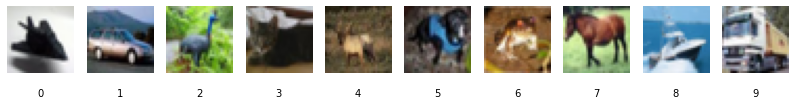

In [12]:
# Display one image for each label.
# 各ラベルについて画像を一つずつ表示する

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(1.4 * 10, 1.4 * 1.5))
for i in range(10):
    ax[i].imshow(train_imgs[i][0])
    ax[i].text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax[i].transAxes)
    ax[i].axis('off')
plt.show()

# Check the Horse images of CIFAR-10 dataset

Select the "horse" images (label number 10) from the CIFAR-10 dataset.
The input values should be in the range [-1, 1].

## CIFAR-10 データセットの「馬」の画像を確認する

CIFAR-10 のデータセットから「馬」の画像(ラベル番号は7)を選び出す。
入力値は [-1, 1] の範囲にすること。

In [13]:
def M1P1_ZeroP1(x):   # [-1.0, 1.0] --> [0.0, 1.0]
    return (x+1)/2

In [14]:
horse_train = (train_imgs[7].astype('float32') - 127.5) / 127.5   # [0, 255] --> [-1.0, 1.0]
horse_test = (test_imgs[7].astype('float32') - 127.5) / 127.5

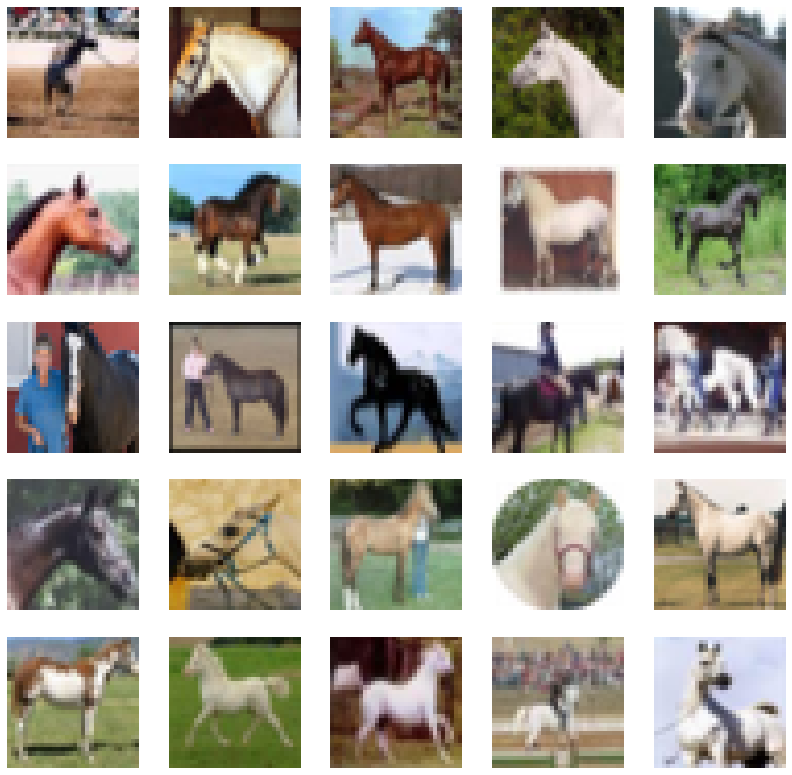

In [15]:
# Display some horse images.
# 馬の画像をいくつか表示してみる

%matplotlib inline
import matplotlib.pyplot as plt

rows = 5
cols = 5

selected_indices = np.random.choice(horse_train.shape[0], rows * cols)
selected_imgs = horse_train[selected_indices]

fig, ax = plt.subplots(rows, cols, figsize=(2.8 * cols, 2.8 * rows))
idx = 0
for row in range(rows):
    for col in range(cols):
        ax[row][col].imshow(M1P1_ZeroP1(selected_imgs[idx]))
        ax[row][col].axis('off')
        idx += 1
plt.show()

# Define the Neural Network Model

## ニューラルネットワーク・モデルを定義する

In [16]:
from nw.WGAN import WGAN

gan = WGAN(
    input_dim=(32, 32, 3),
    critic_conv_filters=[32, 64, 128, 128],
    critic_conv_kernel_size=[5,5,5,5],
    critic_conv_strides=[2,2,2,1],
    critic_batch_norm_momentum=None,
    critic_activation='leaky_relu',     # changed from GAN
    critic_dropout_rate=None,           # changed from GAN
    critic_learning_rate=0.00005,       # changed from GAN
    generator_initial_dense_layer_size=(4, 4, 128),
    generator_upsample=[2,2,2,1],
    generator_conv_filters=[128,64,32,3],
    generator_conv_kernel_size=[5,5,5,5],
    generator_conv_strides=[1,1,1,1],
    generator_batch_norm_momentum=0.8,   # changed from GAN
    generator_activation='leaky_relu',   # changed from GAN
    generator_dropout_rate=None,
    generator_learning_rate=0.00005,     # changed from GAN
    optimizer='rmsprop',
    z_dim=100
)

In [17]:
gan.critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 critic_conv_0 (Conv2D)      (None, 16, 16, 32)        2432      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 32)        0         
                                                                 
 critic_conv_1 (Conv2D)      (None, 8, 8, 64)          51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 critic_conv_2 (Conv2D)      (None, 4, 4, 128)         204928    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0     

In [18]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 2048)              206848    
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 128)        0   

In [19]:
gan.model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 100)]             0         
                                                                 
 model_1 (Functional)        (None, 32, 32, 3)         884163    
                                                                 
 model (Functional)          (None, 1)                 670401    
                                                                 
Total params: 1,554,564
Trainable params: 1,550,020
Non-trainable params: 4,544
_________________________________________________________________


# Training

## 学習

In [20]:
BATCH_SIZE = 128
N_CRITIC = 5
CLIP_THRESHOLD = 0.01

# At first, try training a small number of epoch.

## まず、少ない回数だけ学習してみる


In [21]:
save_path1 = '/content/drive/MyDrive/ColabRun/WGAN_CIFAR01'

In [22]:
x_train = horse_train

gan.train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = 3,
    run_folder = save_path1
)

1 [D loss: -0.000 R -0.000 F 0.000] [G loss: -0.000]  0:00:03.704222
2 [D loss: -0.000 R -0.001 F 0.000] [G loss: -0.001]  0:00:04.129453
3 [D loss: -0.001 R -0.003 F 0.000] [G loss: -0.003]  0:00:04.566187


In [23]:
print(gan.epoch)

3


In [24]:
# Train the model a little more
# もう少し学習を進めてみる

gan.train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = 10,
    run_folder = save_path1
)

4 [D loss: -0.005 R -0.011 F 0.002] [G loss: -0.012]  0:00:00.446908
5 [D loss: -0.012 R -0.031 F 0.007] [G loss: -0.037]  0:00:00.879219
6 [D loss: -0.025 R -0.071 F 0.020] [G loss: -0.088]  0:00:01.288332
7 [D loss: -0.033 R -0.117 F 0.052] [G loss: -0.165]  0:00:01.689561
8 [D loss: -0.035 R -0.162 F 0.092] [G loss: -0.243]  0:00:02.136078
9 [D loss: -0.031 R -0.198 F 0.135] [G loss: -0.297]  0:00:02.561971
10 [D loss: -0.030 R -0.222 F 0.163] [G loss: -0.334]  0:00:03.034563


# Check the loss and accuracy of the training process.

## 学習過程のlossと精度を確認する

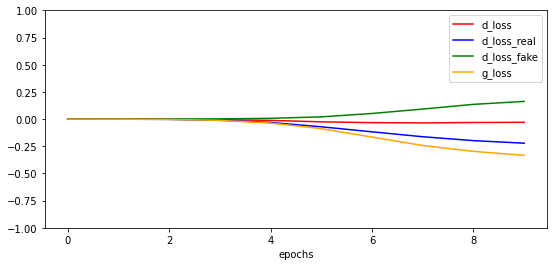

In [25]:
# Display the graph of losses in training
%matplotlib inline

gan.showLoss([],[-1,1])

# Check the saved files

## 保存されているファイルを確認する

In [26]:
! ls -lR {save_path1}

/content/drive/MyDrive/ColabRun/WGAN_CIFAR01:
total 589
-rw------- 1 root root  43469 Nov 23 03:41 params_1000.pkl
-rw------- 1 root root   4294 Nov 23 03:34 params_100.pkl
-rw------- 1 root root    604 Nov 23 06:46 params_10.pkl
-rw------- 1 root root  87473 Nov 23 03:48 params_2000.pkl
-rw------- 1 root root    317 Nov 23 06:46 params_3.pkl
-rw------- 1 root root 175481 Nov 23 04:03 params_4000.pkl
-rw------- 1 root root  21469 Nov 23 03:37 params_500.pkl
-rw------- 1 root root 263489 Nov 23 04:18 params_6000.pkl
-rw------- 1 root root    604 Nov 23 06:46 params.pkl
drwx------ 2 root root   4096 Nov 23 06:46 weights

/content/drive/MyDrive/ColabRun/WGAN_CIFAR01/weights:
total 110268
-rw------- 1 root root 2708296 Nov 23 03:41 critic-weights_1000.h5
-rw------- 1 root root 2708296 Nov 23 03:34 critic-weights_100.h5
-rw------- 1 root root 2708256 Nov 23 06:46 critic-weights_10.h5
-rw------- 1 root root 2708296 Nov 23 03:48 critic-weights_2000.h5
-rw------- 1 root root 2708256 Nov 23 06:

# Load the saved file and try further training.

Load the saved parameters and model weights, and try training further.

## セーブしたファイルをロードして、さらに学習を進める

保存してあるパラメータとモデルの重みをロードして、追加の学習を試みる。

In [27]:
# Load the saved parameters and weights.
# 保存してある学習結果をロードする。

gan_work = WGAN.load(save_path1)

# Display the epoch count of the model.
# training のepoch回数を表示する。

print(gan_work.epoch)

10


In [28]:
# Training in addition
# 追加で training する。

gan_work.train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = 100,
    run_folder = save_path1
)

11 [D loss: -0.029 R -0.256 F 0.198] [G loss: -0.369]  0:00:02.324688
12 [D loss: -0.014 R -0.254 F 0.226] [G loss: -0.307]  0:00:02.793013
13 [D loss: -0.017 R -0.239 F 0.204] [G loss: -0.243]  0:00:03.211906
14 [D loss: -0.031 R -0.229 F 0.167] [G loss: -0.174]  0:00:03.635672
15 [D loss: -0.047 R -0.237 F 0.142] [G loss: -0.111]  0:00:04.088722
16 [D loss: -0.054 R -0.227 F 0.119] [G loss: -0.065]  0:00:04.551696
17 [D loss: -0.067 R -0.255 F 0.120] [G loss: -0.045]  0:00:04.969188
18 [D loss: -0.033 R -0.240 F 0.175] [G loss: -0.064]  0:00:05.384153
19 [D loss: 0.000 R -0.251 F 0.252] [G loss: -0.106]  0:00:05.910306
20 [D loss: 0.023 R -0.218 F 0.264] [G loss: -0.129]  0:00:06.349465
21 [D loss: 0.047 R -0.168 F 0.262] [G loss: -0.123]  0:00:06.784429
22 [D loss: 0.049 R -0.136 F 0.235] [G loss: -0.107]  0:00:07.224099
23 [D loss: 0.035 R -0.097 F 0.168] [G loss: -0.078]  0:00:07.666756
24 [D loss: 0.028 R -0.066 F 0.123] [G loss: -0.049]  0:00:08.125826
25 [D loss: 0.015 R -0.048

In [29]:
%matplotlib inline 

# prepare the noise vectors
# ノイズ・ベクトルを用意する。

if False:
    rows, cols = 5, 5

    noise = np.random.normal(0, 1, (rows * cols, gan.z_dim))

    imgs = gan_work.generator.predict(noise)
    imgs = 0.5 * (imgs + 1)
    imgs = np.clip(imgs, 0, 1)
    #imgs = gan.generate_images(noise).squeeze()
    WGAN.showImages(imgs, rows, cols, 1.4, 1.4)

In [30]:
# Training in addition
# 追加で training する。

gan_work.train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = 500,
    run_folder = save_path1
)

101 [D loss: -0.079 R 0.081 F -0.239] [G loss: 0.222]  0:00:00.431941
102 [D loss: -0.060 R 0.115 F -0.235] [G loss: 0.251]  0:00:00.909651
103 [D loss: -0.069 R 0.119 F -0.257] [G loss: 0.281]  0:00:01.345767
104 [D loss: -0.075 R 0.135 F -0.286] [G loss: 0.319]  0:00:01.798428
105 [D loss: -0.072 R 0.204 F -0.347] [G loss: 0.375]  0:00:02.214320
106 [D loss: -0.097 R 0.249 F -0.442] [G loss: 0.452]  0:00:02.636974
107 [D loss: -0.122 R 0.346 F -0.589] [G loss: 0.561]  0:00:03.064685
108 [D loss: -0.135 R 0.425 F -0.696] [G loss: 0.653]  0:00:03.484813
109 [D loss: -0.134 R 0.525 F -0.793] [G loss: 0.741]  0:00:03.932866
110 [D loss: -0.118 R 0.622 F -0.858] [G loss: 0.807]  0:00:04.357276
111 [D loss: -0.116 R 0.587 F -0.820] [G loss: 0.841]  0:00:04.783043
112 [D loss: -0.057 R 0.583 F -0.696] [G loss: 0.835]  0:00:05.268107
113 [D loss: -0.019 R 0.584 F -0.622] [G loss: 0.766]  0:00:05.688762
114 [D loss: 0.014 R 0.566 F -0.538] [G loss: 0.712]  0:00:06.098878
115 [D loss: -0.000 R

In [31]:
# Training in addition
# 追加で training する。

gan_work.train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = 1000,
    run_folder = save_path1
)

501 [D loss: -0.010 R -0.043 F 0.022] [G loss: -0.011]  0:00:00.448400
502 [D loss: -0.016 R -0.042 F 0.010] [G loss: -0.009]  0:00:00.912250
503 [D loss: -0.012 R -0.043 F 0.019] [G loss: -0.003]  0:00:01.351265
504 [D loss: -0.010 R -0.048 F 0.029] [G loss: -0.003]  0:00:01.797373
505 [D loss: -0.010 R -0.042 F 0.022] [G loss: -0.004]  0:00:02.245250
506 [D loss: -0.009 R -0.042 F 0.024] [G loss: -0.008]  0:00:02.689118
507 [D loss: -0.008 R -0.043 F 0.028] [G loss: -0.018]  0:00:03.123546
508 [D loss: -0.001 R -0.041 F 0.039] [G loss: -0.023]  0:00:03.559731
509 [D loss: -0.006 R -0.037 F 0.025] [G loss: -0.019]  0:00:04.000654
510 [D loss: -0.006 R -0.038 F 0.026] [G loss: -0.013]  0:00:04.448661
511 [D loss: -0.007 R -0.046 F 0.032] [G loss: -0.014]  0:00:04.895201
512 [D loss: -0.011 R -0.048 F 0.026] [G loss: -0.015]  0:00:05.427405
513 [D loss: -0.016 R -0.052 F 0.019] [G loss: -0.014]  0:00:05.836803
514 [D loss: -0.016 R -0.050 F 0.019] [G loss: -0.016]  0:00:06.292616
515 [D

In [32]:
# Training in addition
# 追加で training する。

gan_work.train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = 6000,
    run_folder = save_path1,
    print_every_n_batches = 2000
)

1001 [D loss: -0.016 R -0.062 F 0.029] [G loss: -0.013]  0:00:00.455162
1002 [D loss: -0.011 R -0.059 F 0.036] [G loss: -0.014]  0:00:00.921511
1003 [D loss: -0.017 R -0.057 F 0.024] [G loss: -0.008]  0:00:01.378079
1004 [D loss: -0.016 R -0.054 F 0.022] [G loss: -0.008]  0:00:01.829481
1005 [D loss: -0.010 R -0.052 F 0.032] [G loss: -0.016]  0:00:02.295974
1006 [D loss: -0.013 R -0.057 F 0.031] [G loss: -0.014]  0:00:02.700287
1007 [D loss: -0.016 R -0.051 F 0.019] [G loss: -0.020]  0:00:03.163454
1008 [D loss: -0.014 R -0.060 F 0.031] [G loss: -0.020]  0:00:03.606801
1009 [D loss: -0.009 R -0.056 F 0.038] [G loss: -0.024]  0:00:04.040583
1010 [D loss: -0.014 R -0.061 F 0.032] [G loss: -0.014]  0:00:04.468204
1011 [D loss: -0.012 R -0.054 F 0.030] [G loss: -0.012]  0:00:04.888747
1012 [D loss: -0.013 R -0.056 F 0.031] [G loss: -0.010]  0:00:05.373965
1013 [D loss: -0.015 R -0.059 F 0.029] [G loss: -0.010]  0:00:05.842795
1014 [D loss: -0.008 R -0.049 F 0.032] [G loss: -0.015]  0:00:06

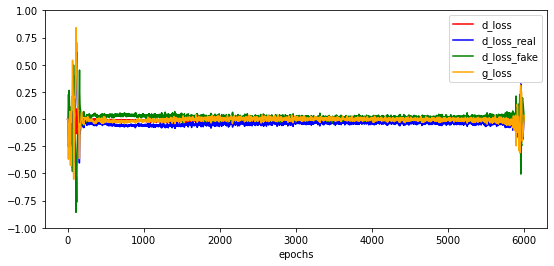

In [33]:
# Display the graph of losses in training
%matplotlib inline

gan_work.showLoss([],[-1,1])

# Generate Images from 100-dimensional noise vector and select original images similar to each.

# 100次元のノイズ・ベクトルから画像を生成してみる。

In [45]:
# prepare the noise vectors
# ノイズ・ベクトルを用意する。

rows, cols = 2, 10

noise = np.random.normal(0, 1, (rows * cols, gan_work.z_dim))

In [46]:
! ls -lR {save_path1}

/content/drive/MyDrive/ColabRun/WGAN_CIFAR01:
total 846
-rw------- 1 root root  43469 Nov 23 06:53 params_1000.pkl
-rw------- 1 root root   4294 Nov 23 06:46 params_100.pkl
-rw------- 1 root root    604 Nov 23 06:46 params_10.pkl
-rw------- 1 root root  87473 Nov 23 07:01 params_2000.pkl
-rw------- 1 root root    317 Nov 23 06:46 params_3.pkl
-rw------- 1 root root 175481 Nov 23 07:15 params_4000.pkl
-rw------- 1 root root  21469 Nov 23 06:49 params_500.pkl
-rw------- 1 root root 263489 Nov 23 07:30 params_6000.pkl
-rw------- 1 root root 263489 Nov 23 07:30 params.pkl
drwx------ 2 root root   4096 Nov 23 07:30 weights

/content/drive/MyDrive/ColabRun/WGAN_CIFAR01/weights:
total 110268
-rw------- 1 root root 2708296 Nov 23 06:53 critic-weights_1000.h5
-rw------- 1 root root 2708296 Nov 23 06:46 critic-weights_100.h5
-rw------- 1 root root 2708256 Nov 23 06:46 critic-weights_10.h5
-rw------- 1 root root 2708296 Nov 23 07:01 critic-weights_2000.h5
-rw------- 1 root root 2708256 Nov 23 06:

epoch 3


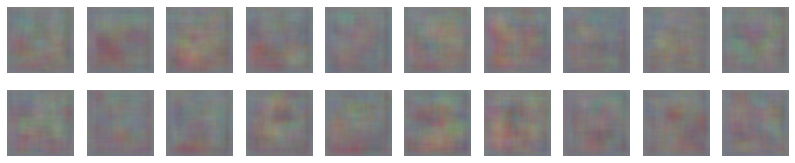

epoch 10


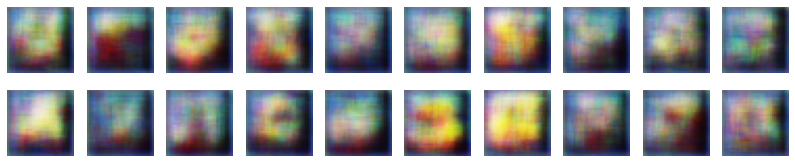

epoch 100


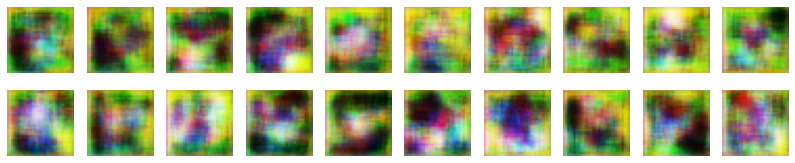

epoch 500


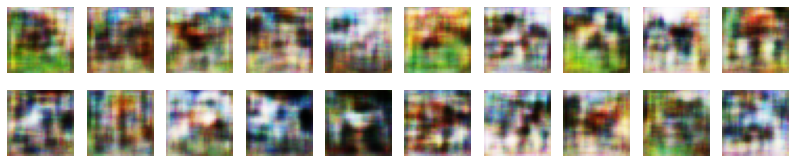

epoch 1000


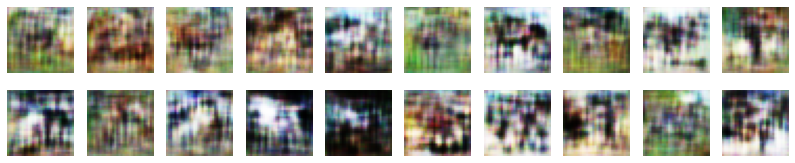

epoch 2000


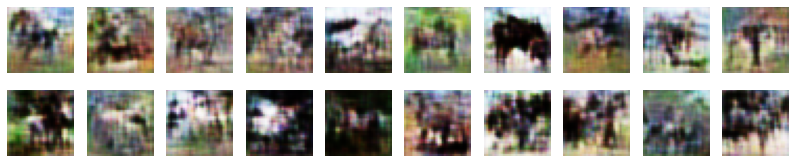

epoch 4000


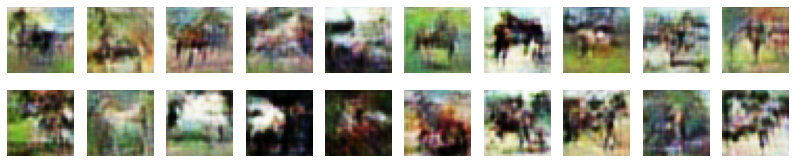

epoch 6000


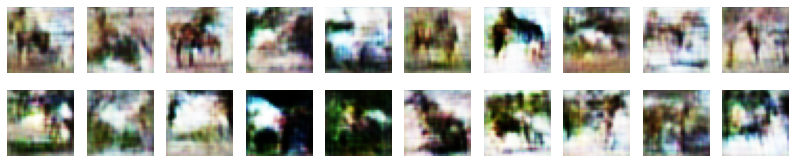

In [47]:
%matplotlib inline

for i in [3, 10, 100, 500, 1000, 2000, 4000, 6000]:
    gan = WGAN.load(save_path1, i)
    imgs = gan.generate_images(noise).squeeze()
    print(f'epoch {i}')
    WGAN.showImages(imgs, rows, cols, 1.4, 1.4)

# Analysis after training

# 学習後の解析

# Function to select the most similar image from the x_train images.

## ある画像に対して、学習用画像の中から最も似た画像を選ぶ関数

In [37]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [38]:
def most_similar(target, imgs):
    idx = -1
    d_min = 99999
    for i, img in enumerate(imgs):
        if i == 0:
            idx = 0
            d_min = compare_images(target, img)
        else:
            d = compare_images(target, img)
            if d < d_min:
                idx = i
                d_min = d
    return imgs[idx]

# Generate images from 100-dimensional noise vectors and select original images

## 100次元のノイズ・ベクトルから画像を生成し、似ている原画像を選ぶ

In [39]:
# load the most trained model.
# 最も学習が進んだモデルをロードする。

gan = WGAN.load(save_path1)

In [40]:
n_to_show = 10

# prepare noise vectors
# ノイズ・ベクトルを用意する
noise = np.random.normal(0, 1, (n_to_show, gan.z_dim))   # mean:0, scale=1 --> [-1, 1]

# Generate images from noise vectors.
# ノイズベクトルから画像を生成する
gen_imgs = gan_work.generate_images(noise)


In [41]:
# The value range of the x_train is [-1, 1]. It needs to be changed to [0, 1] to compare with images.
# x_train のデータは値の範囲が [-1, 1] になっている。画像と比較するには [0, 1] に変更する必要がある。

x_train_img = (x_train + 1) /2
x_train_img = np.clip(x_train_img, 0, 1)

In [42]:
# Select the most similar image of x_train to each image generated.
# 生成した各画像に最も似ている x_train の画像を選ぶ

similar_imgs = []
for gen in gen_imgs:
    ori = most_similar(gen, x_train_img)
    similar_imgs.append(ori)

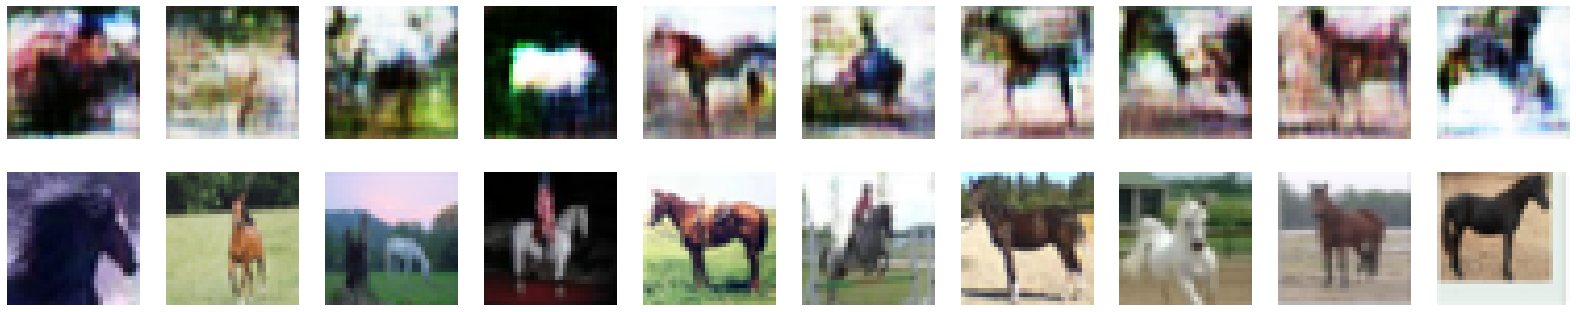

In [43]:
# Display the pairs of generated image and original image.
# 生成画像と、似ている原画像のペアを表示する。

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, n_to_show, figsize=(2.8 * n_to_show, 2.8 * 2))
for i in range(n_to_show):
    ax[0][i].imshow(gen_imgs[i])
    ax[0][i].axis('off')
    ax[1][i].imshow(similar_imgs[i])
    ax[1][i].axis('off')
plt.show()